# Project 2: The Dijkstra’s Algorithm

## Set up

### import

In [120]:
import random
import time
import math
import heapq
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [121]:
# random.seed(42)
# np.random.seed(42)

INF = float('inf')

### dijkstra adjacency matrix

In [122]:
def adjacency_list_to_matrix(V, E):
    """
    Convert adjacency list to adjacency matrix.

    Parameters
    ----------
    V : iterable
        Nodes in the graph
    E : dict
        Adjacency list: node -> list of (neighbor, weight)

    Returns
    -------
    adj_matrix : list of list
        n x n adjacency matrix where n = len(V)
    index : dict
        Mapping from node -> matrix index
    nodes : list
        List of nodes in order of matrix indices
    """
    nodes = list(V)
    n = len(nodes)
    index = {node: i for i, node in enumerate(nodes)}

    # Initialize matrix with infinity
    adj_matrix = [[float('inf')] * n for _ in range(n)]

    for u in nodes:
        for v, w in E.get(u, []):
            adj_matrix[index[u]][index[v]] = w

    return adj_matrix

In [123]:
def dijkstra_matrix_array(adj_matrix, start):
    """
    Dijkstra's algorithm using adjacency matrix and array-based priority queue.

    Parameters
    ----------
    adj_matrix : list of list
        n x n adjacency matrix. Use float('inf') for no edge.
    start : int
        Index of the starting node (0-based)

    Returns
    -------
    dist : list
        Shortest distance from start to each node
    prev : list
        Previous node in the shortest path (None if no predecessor)
    """
    V = len(adj_matrix)
    
    # Initialize distances and visited set
    dist = [float('inf')] * V
    dist[start] = 0
    visited = [False] * V
    prev = [None] * V  # To store shortest path tree
    
    for _ in range(V):
        # Find the unvisited vertex with the smallest distance
        u = -1
        min_dist = float('inf')
        for i in range(V):
            if not visited[i] and dist[i] < min_dist:
                min_dist = dist[i]
                u = i
        
        if u == -1:  # All remaining vertices are inaccessible
            break
        
        visited[u] = True
        
        # Relax edges from u
        for v in range(V):
            weight = adj_matrix[u][v]
            if not visited[v]: 
                if dist[u] + weight < dist[v]:
                    dist[v] = dist[u] + weight
                    prev[v] = u
    
    return dist, prev

### dijkstra heap

In [124]:
def dijkstra_adjlist_heap(V, E, start):
    """
    Dijkstra's algorithm using adjacency list and a min-heap priority queue.
    
    Parameters:
    V : iterable
        Nodes in the graph
    E : dict
        Adjacency list: node -> list of (neighbor, weight)
    start : node
        Starting node
    
    Returns:
    dist : dict
        Shortest distances from start to each node
    prev : dict
        Previous node in the shortest path
    """
    dist = {node: float('inf') for node in V}
    prev = {node: None for node in V}
    dist[start] = 0
    
    # Min-heap of (distance, node)
    heap = [(0, start)]
    
    while heap:
        current_dist, u = heapq.heappop(heap)
        
        # Skip if this distance is not the latest
        if current_dist > dist[u]:
            continue
        
        for neighbor, weight in E.get(u, []):
            if dist[u] + weight < dist[neighbor]:
                dist[neighbor] = dist[u] + weight
                prev[neighbor] = u
                heapq.heappush(heap, (dist[neighbor], neighbor))
    
    return dist, prev

### Generate Graph

In [125]:
def generate_graph_with_VE(num_vertices, num_edges, max_weight=10, directed=True):
    """
    Generate a random weighted graph with exactly |V| vertices and ~|E| edges.
    Graph is stored as adjacency list: dict {u: [(v, w), ...], ...}.
    
    - num_vertices: number of nodes (|V|)
    - num_edges: number of edges (|E|)
    - max_weight: maximum edge weight
    - directed: True -> directed graph, False -> undirected
    """
    V = list(range(num_vertices))
    E = {u: [] for u in V}
    
    # total possible edges
    if directed:
        possible_edges = [(u, v) for u in V for v in V if u != v]
    else:
        possible_edges = [(u, v) for u in V for v in V if u < v]
    
    if num_edges > len(possible_edges):
        raise ValueError("Too many edges requested for given number of vertices")
    
    # sample exactly |E| edges
    chosen_edges = random.sample(possible_edges, num_edges)
    
    for (u, v) in chosen_edges:
        w = random.randint(1, max_weight)
        E[u].append((v, w))
        if not directed:
            E[v].append((u, w))
    
    return V, E

### Visualizing

In [126]:
def draw_original_graph(V, E, pos=None, figsize=(8,6), title="Original Graph", layout="circular"):
    G = nx.DiGraph()
    # ensure all nodes present
    for u in V:
        G.add_node(u)
    for u in V:
        for v, w in E.get(u, []):
            G.add_edge(u, v, weight=w)

    if pos is None:
        if layout == "circular":
            pos = nx.circular_layout(G)       # Nodes in a circle
        elif layout == "linear":
            pos = {v: (v, 0) for v in V}      # Nodes in a straight line (sequential order)
        elif layout == "kamada":
            pos = nx.kamada_kawai_layout(G)   # Distance-based placement
        else:
            pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=figsize)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=800, font_weight="bold")
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(title)
    plt.show()
    return pos

def draw_shortest_path_tree_from_pi(V, E, d, pi, start, pos=None, figsize=(8,6),
                                   title="Shortest Path Tree", layout="circular"):
    """
    Uses the provided d and pi (from Dijkstra) to highlight the shortest-path tree.
    Node labels include the distance value (or '∞' if unreachable).
    """
    G = nx.DiGraph()
    # ensure all nodes present
    for u in V:
        G.add_node(u)
    # add edges
    for u in V:
        for v, w in E.get(u, []):
            G.add_edge(u, v, weight=w)

    if pos is None:
        if layout == "circular":
            pos = nx.circular_layout(G)       # Nodes in a circle
        elif layout == "linear":
            pos = {v: (v, 0) for v in V}      # Nodes in a straight line (sequential order)
        elif layout == "kamada":
            pos = nx.kamada_kawai_layout(G)   # Distance-based placement
        else:
            pos = nx.spring_layout(G, seed=42)

    # Build tree edges from pi (use only valid predecessors)
    tree_edges = [(pi[v], v) for v in V if pi.get(v) is not None]

    # Node labels include distance (∞ for unreachable)
    node_labels = {node: f"{node}\n{(d[node] if d[node] != float('inf') else '∞')}" for node in V}

    plt.figure(figsize=figsize)
    # draw base graph
    nx.draw(G, pos, with_labels=False, node_color="lightgray", node_size=700, alpha=0.9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
    # draw nodes with distance labels on top
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=700)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_weight="bold")
    # highlight tree edges (if any)
    if tree_edges:
        nx.draw_networkx_edges(G, pos, edgelist=tree_edges, edge_color="red", width=2.2)
    # mark start node
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color="gold", node_size=900)
    if title is None:
        title = f"Shortest-Path Tree from {start} (distances shown)"
    plt.title(title)
    plt.show()


### Trials

In [127]:
def time_trial(v, e, trials=3):
    t_matrix = []
    t_adj = []
    for _ in range(trials):
        V, E = generate_graph_with_VE(num_vertices=v, num_edges=e)
        src = 0
        # time matrix-array dijkstra
        adj_matrix = adjacency_list_to_matrix(V, E)  # ensure conversion done outside timing
        t0 = time.perf_counter()
        d1 = dijkstra_matrix_array(adj_matrix, src)
        t1 = time.perf_counter()
        # time adjlist-heap dijkstra
        t2 = time.perf_counter()
        d2 = dijkstra_adjlist_heap(V, E, src)
        t3 = time.perf_counter()
        # sanity check: distances should be equal (or both INF) — small numerical difference possible
        # We'll skip strict check to avoid extra overhead but ensure same lengths
        t_matrix.append(t1-t0)
        t_adj.append(t3-t2)
    return sum(t_matrix)/len(t_matrix), sum(t_adj)/len(t_adj)

## Experiment

### Example 1

Using adjacency matrix + array-based priority queue:
Shortest distances (d): [0, inf, inf, inf, 7, inf, 27, 16]
Predecessors (pi): [None, None, None, None, 0, None, 7, 4]

Using adjacency list + heap-based priority queue:
Shortest distances (d): [0, inf, inf, inf, 7, inf, 27, 16]
Predecessors (pi): [None, None, None, None, 0, None, 7, 4]


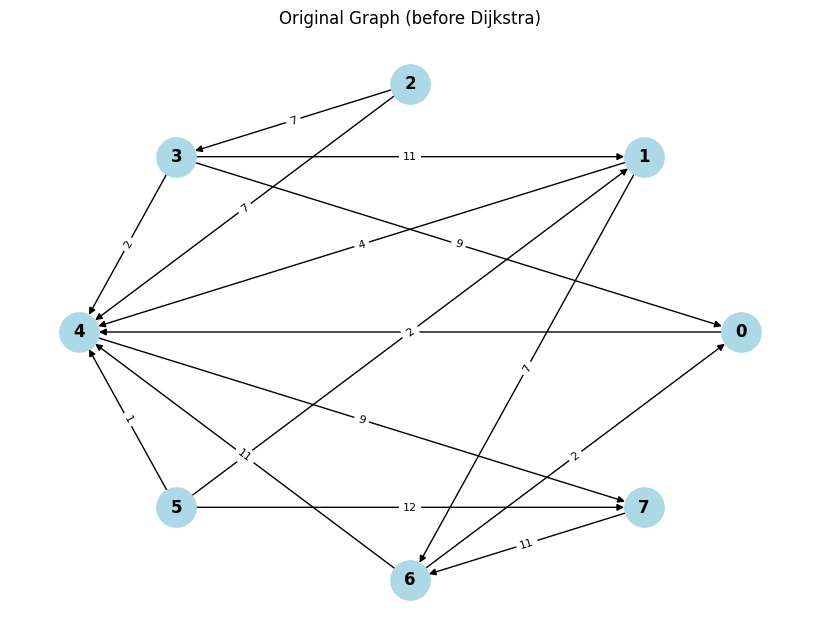

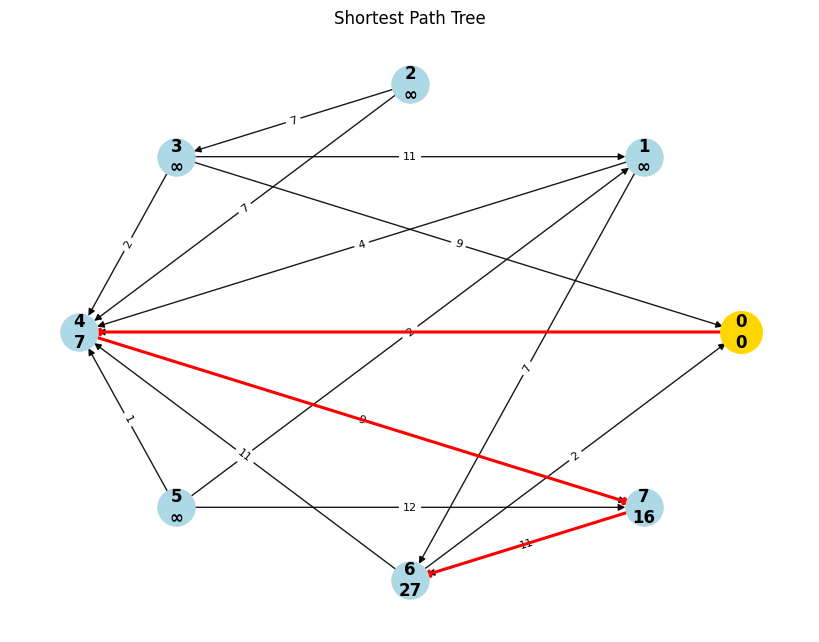

In [128]:
V, E = generate_graph_with_VE(num_vertices=8, num_edges=15, max_weight=12, directed=True)
start = 0

matrix = adjacency_list_to_matrix(V, E)
# compute d and pi using matrix
d, pi = dijkstra_matrix_array(matrix, start)
print("Using adjacency matrix + array-based priority queue:")
print("Shortest distances (d):", d)
print("Predecessors (pi):", pi)

# compute d and pi using dijkstra
d, pi = dijkstra_adjlist_heap(V, E, start)
print("\nUsing adjacency list + heap-based priority queue:")
print("Shortest distances (d):", list(d.values()))
print("Predecessors (pi):", list(pi.values()))

# get a consistent layout, draw original graph
pos = draw_original_graph(V, E, pos=None, title="Original Graph (before Dijkstra)", layout="circular")

# draw using the produced d and pi
draw_shortest_path_tree_from_pi(V, E, d, pi, start, pos=pos)

### Time vs Edges

In [129]:
# Experiment parameters
sizes = [400, 800, 1600, 3200] 
trials_per_point = 3

results = []
for size in sizes:
    min_edges = size
    max_edges = size * (size - 1)

    edges = [min_edges + i * (max_edges - min_edges) // 9 for i in range(1, 10)]
    for edge in edges:
        try:
            tm, ta = time_trial(size, edge, trials=trials_per_point)
        except ValueError:
            continue
        results.append({'n': size, 'e': edge, 'time_matrix_array': tm, 'time_adjlist_heap': ta})
df = pd.DataFrame(results)

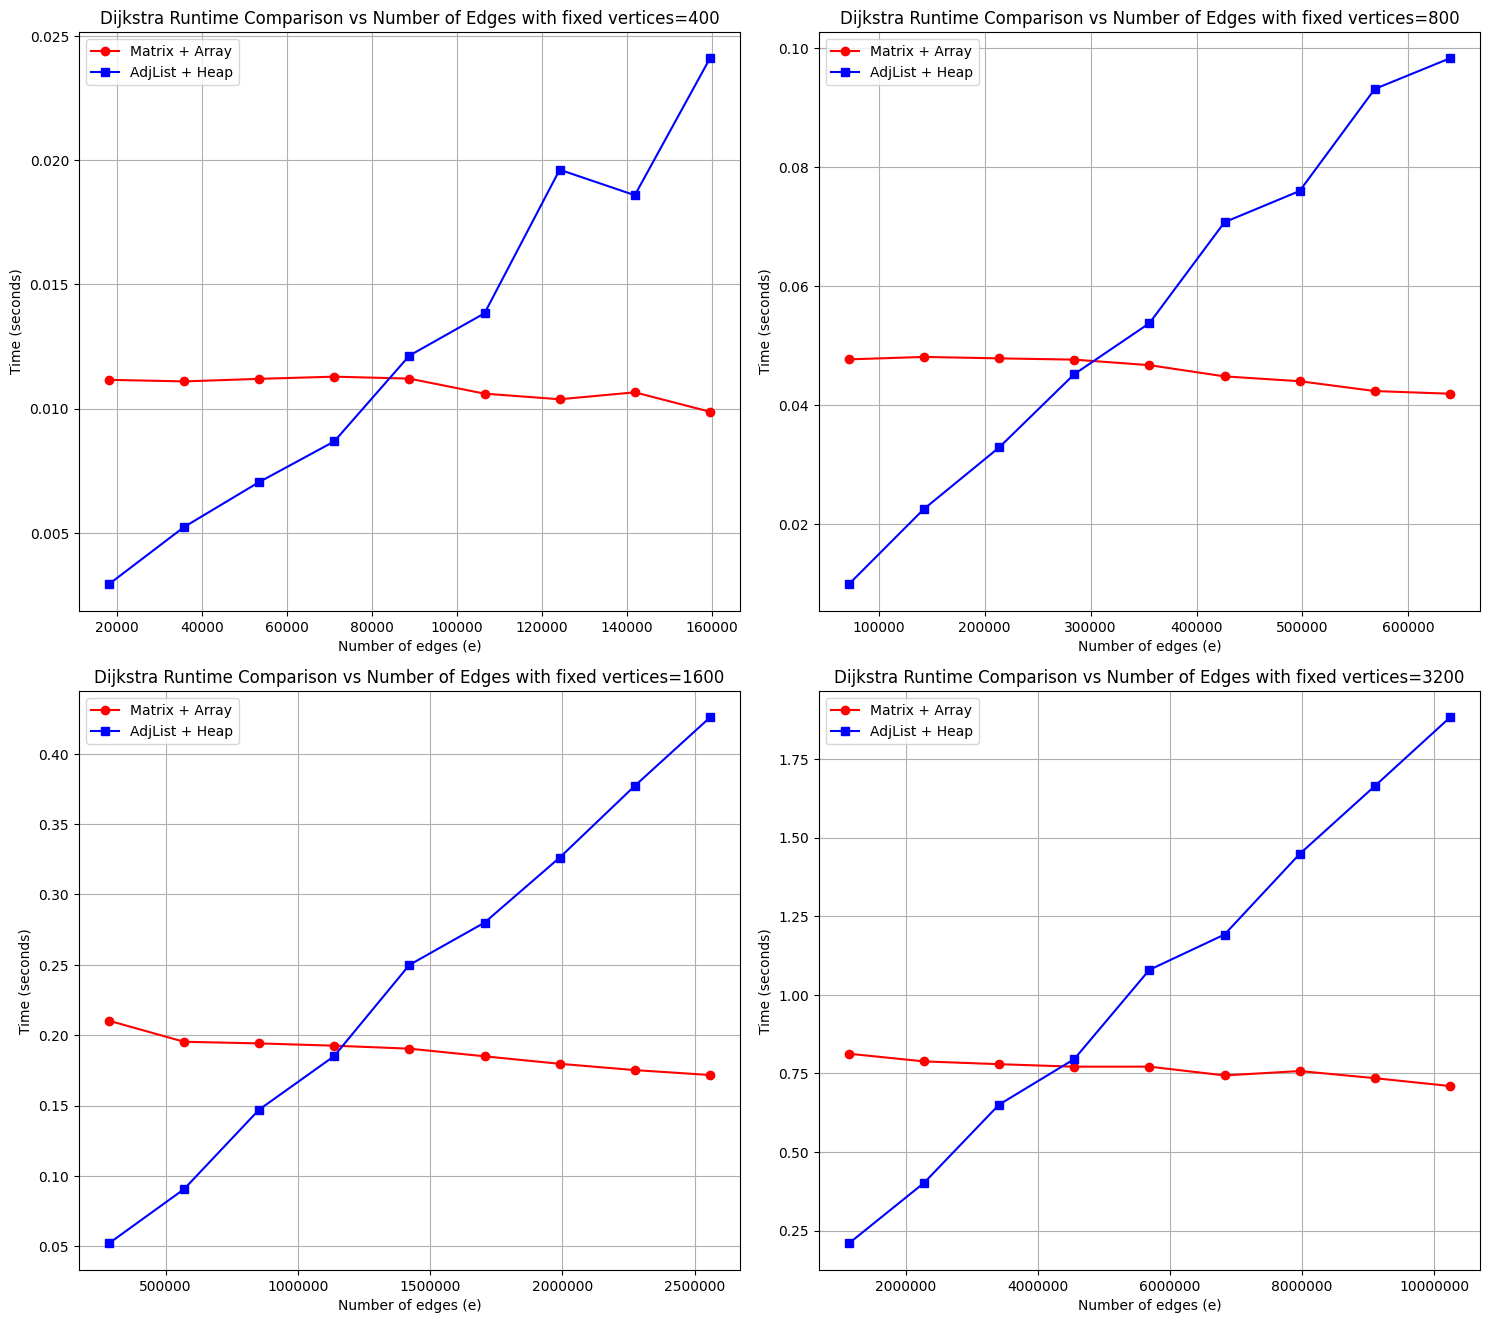

In [130]:
# Extract data
sizes = set([r['n'] for r in results])
sizes = sorted(sizes)

fig, axes = plt.subplots((len(sizes)+1)//2, 2, figsize=(15,20/3*2))
axes = axes.flatten()
for i, e in enumerate(sizes):
    respective_edges = []
    tm = []
    ta = []
    for r in results:
        if r['n'] == e:
            respective_edges.append(r['e'])
            tm.append(r['time_matrix_array'])
            ta.append(r['time_adjlist_heap'])
    # 2️Plot runtime vs number of edges
    axes[i].plot(respective_edges, tm, 'o-', label='Matrix + Array', color='red')
    axes[i].plot(respective_edges, ta, 's-', label='AdjList + Heap', color='blue')
    axes[i].set_xlabel('Number of edges (e)')
    axes[i].set_ylabel('Time (seconds)')
    axes[i].set_title('Dijkstra Runtime Comparison vs Number of Edges with fixed vertices={}'.format(e))
    axes[i].ticklabel_format(style='plain', axis='x')
    axes[i].ticklabel_format(style='plain', axis='y')
    axes[i].legend()
    axes[i].grid(True)
plt.tight_layout()
plt.show()

### Time vs Vertics

In [131]:
# Experiment parameters
edges = [100, 200, 400, 800, 1600, 3200] 
trials_per_point = 3

results = []
for edge in edges:
    min_size = int(edge**0.5) - 1
    max_size = edge

    sizes = [min_size + i * (max_size - min_size) // 9 for i in range(10)]
    for size in sizes:
        try:
            tm, ta = time_trial(size, edge, trials=trials_per_point)
        except ValueError:
            continue
        results.append({'n': size, 'e': edge, 'time_matrix_array': tm, 'time_adjlist_heap': ta})
df = pd.DataFrame(results)

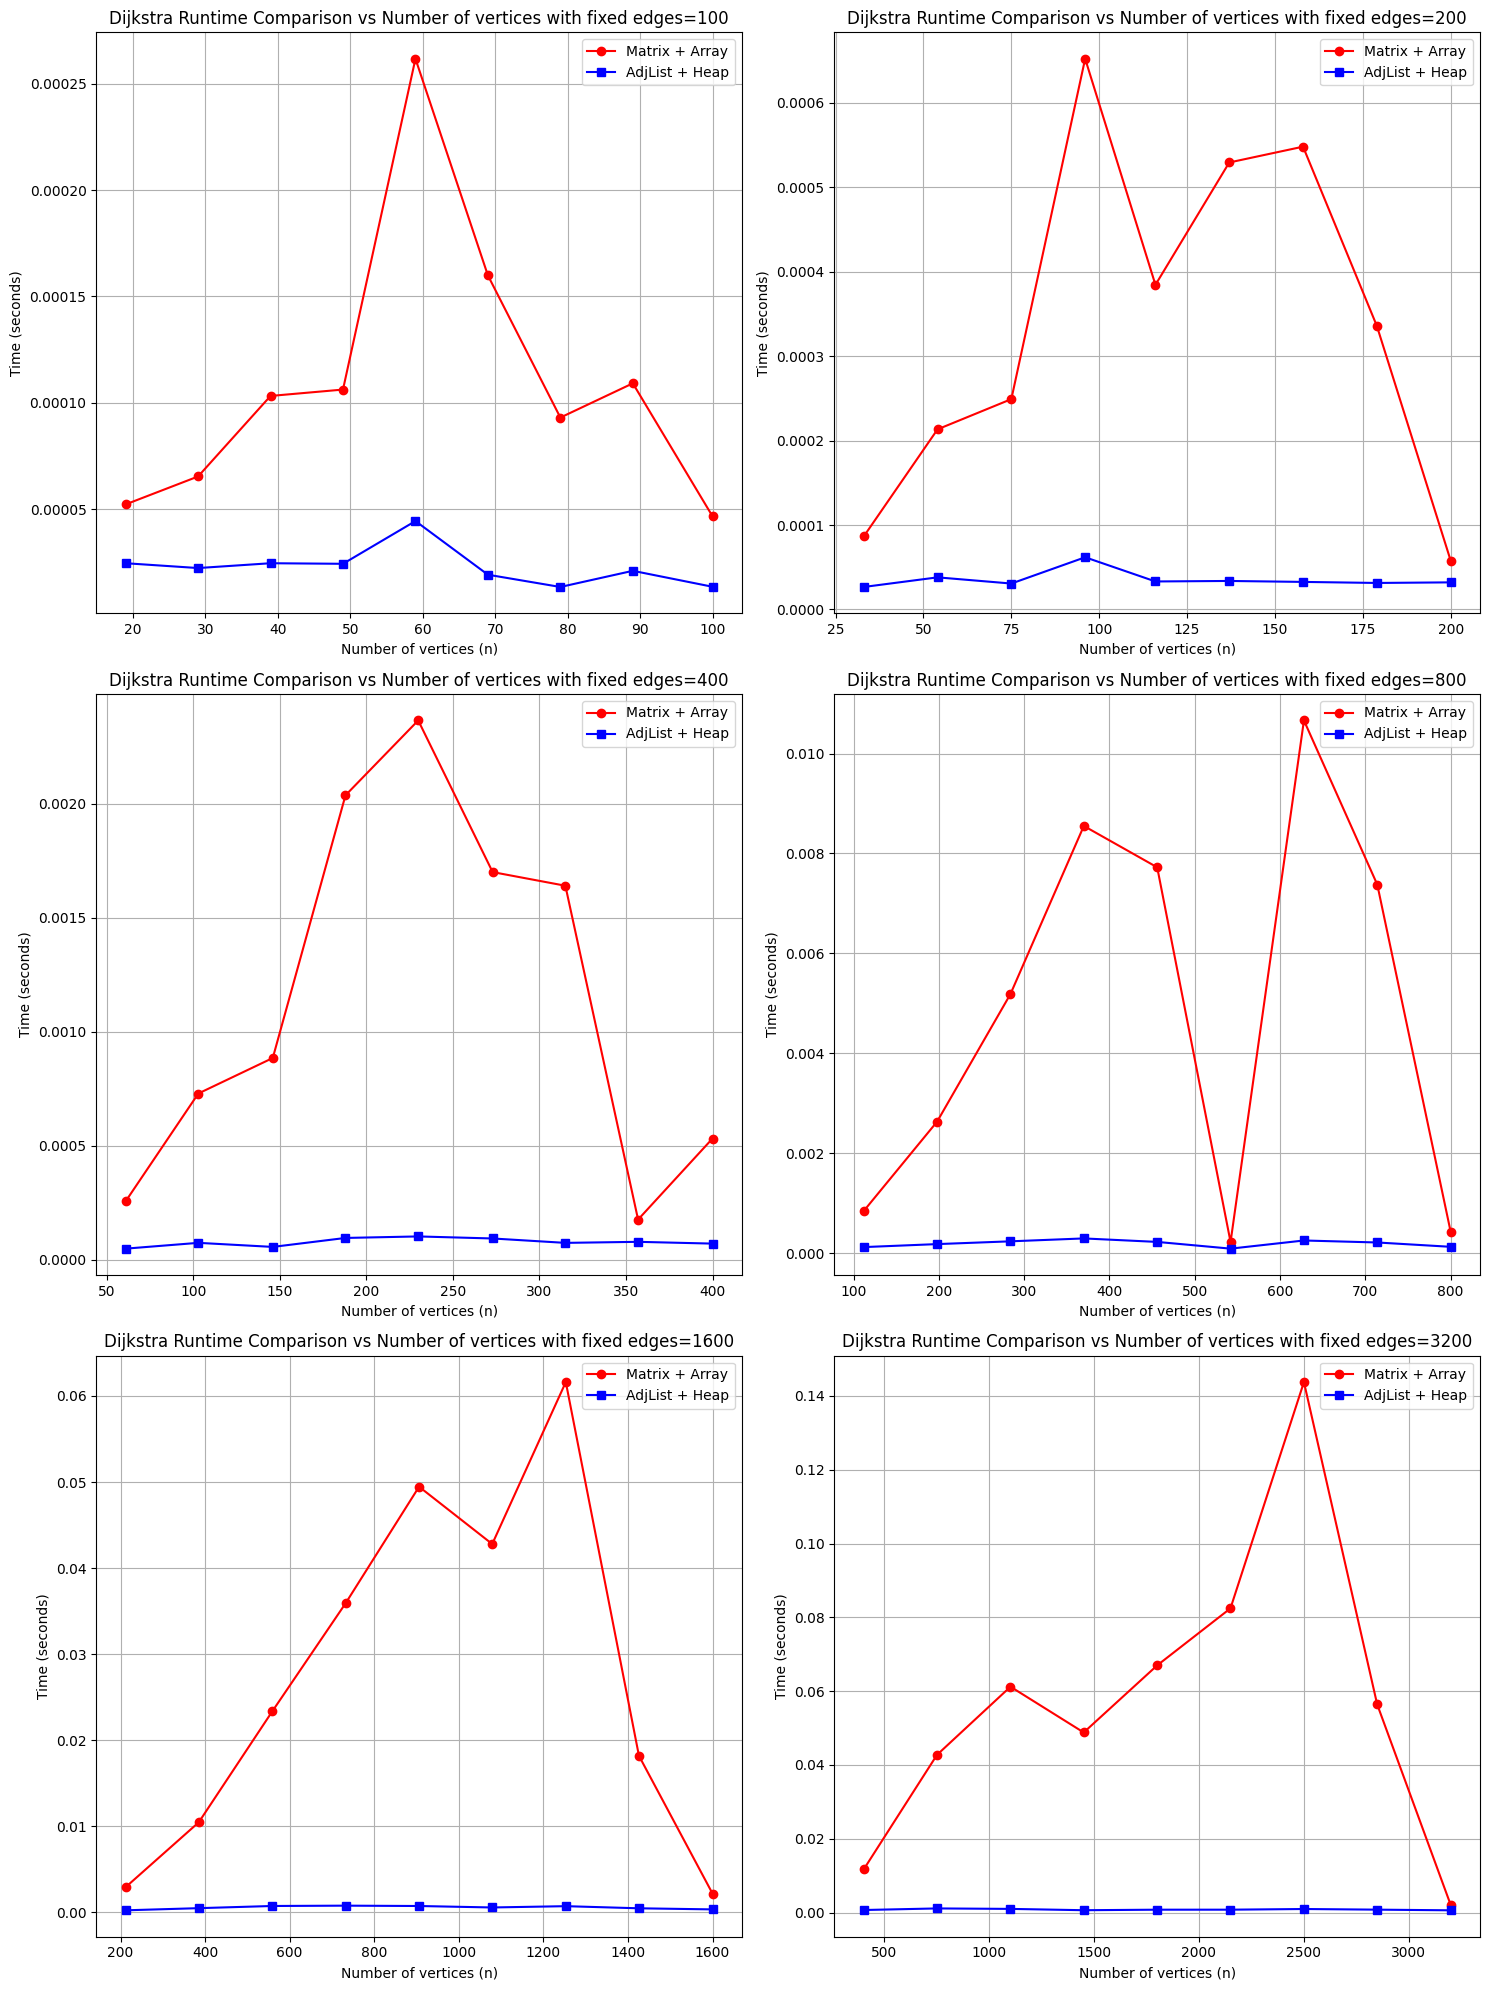

In [132]:
# Extract data
edges = set([r['e'] for r in results])
edges = sorted(edges)

fig, axes = plt.subplots((len(edges)+1)//2, 2, figsize=(15,20))
axes = axes.flatten()
for i, e in enumerate(edges):
    respective_sizes = []
    tm = []
    ta = []
    for r in results:
        if r['e'] == e:
            respective_sizes.append(r['n'])
            tm.append(r['time_matrix_array'])
            ta.append(r['time_adjlist_heap'])
    # 2️Plot runtime vs number of edges
    axes[i].plot(respective_sizes, tm, 'o-', label='Matrix + Array', color='red')
    axes[i].plot(respective_sizes, ta, 's-', label='AdjList + Heap', color='blue')
    axes[i].set_xlabel('Number of vertices (n)')
    axes[i].set_ylabel('Time (seconds)')
    axes[i].set_title('Dijkstra Runtime Comparison vs Number of vertices with fixed edges={}'.format(e))
    axes[i].ticklabel_format(style='plain', axis='x')
    axes[i].ticklabel_format(style='plain', axis='y')
    axes[i].legend()
    axes[i].grid(True)
plt.tight_layout()
plt.show()